# Face Recognition - Predicting Celebrity Faces

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import re
import glob

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from IPython.display import Image, display
from PIL import Image


Using TensorFlow backend.


### Load in Preprocessed Data

In [2]:
#grab images
image_dir = os.path.join('./images')

In [3]:
#function to grab only the name of folders without number
def subject_names(data_folder_path):
    base_dir = os.listdir(data_folder_path)
    class_names = []
    
    #loop throough each folder path and add to list
    for dir_name in sorted(base_dir):
        #to ignore system files (.DS_Store)
        if dir_name.startswith("."):
            continue;
        new_name = re.sub('[0-9]', '', dir_name)
        class_names.append(new_name)
        
    return class_names

In [4]:
#will use class_names later for predictions
class_names = subject_names(image_dir)
class_names

['Abhishek Sharma',
 'Anne_Hathaway',
 'Ben_Cho',
 'Dave_Chappelle',
 'Elizabeth_Olsen',
 'Jessica_Alba',
 'Kenghshin_Lai',
 'Mark_Popovich',
 'Nicole_Look',
 'Polina_Mitrikovskaia',
 'Terra_Riley',
 'Uday_Datta',
 'Vijay_Swamy',
 'Will_Suh',
 'Zac_Efron']

In [5]:
# this function is to just get the numbers after the file name
def get_numbers(dir_name):
    digits = re.compile(r'\d+')
    digit = [int(x) for x in digits.findall(dir_name)]
    
    return digit


#just to test out grabbing each label number so that I can implement into the next function
def label_number(data_folder_path):
    base_dir = os.listdir(data_folder_path)
    labels = []
    
    for dir_name in base_dir:
        #ignore system files
        if dir_name.startswith("."):
            continue;
        label = get_numbers(dir_name)
        labels.append(label)
        
    return labels

In [6]:
#see if it works
labels = label_number(image_dir)
labels

[[14],
 [11],
 [8],
 [3],
 [4],
 [5],
 [10],
 [12],
 [0],
 [9],
 [13],
 [2],
 [6],
 [1],
 [7]]

In [7]:
#function to prepare images for model
def prepare_training_data(data_folder_path):
    base_dir = os.listdir(data_folder_path)
    
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #let's go through each directory and read images within it
    for dir_name in base_dir:
        
        #extract label number of subject from dir_name
        if dir_name.startswith("."):
            continue;
        label = get_numbers(dir_name)
        
        #build path of directory containin images for current subject subject
        subject_dir_path = data_folder_path + "/" + dir_name
        
        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)

        #go through each image name, read image, 
        for image_name in subject_images_names:
          
            #build image path
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            if image is not None:
                faces.append(image)
                labels.append(label)

    return faces, labels

In [8]:
#execute function with dataset
faces, labels = prepare_training_data(image_dir)

In [9]:
#number of faces
len(faces)

5701

In [10]:
#reshape the images to proper format
reshaped_faces = np.concatenate(faces, axis=0).reshape(len(faces),175,175,3)

In [11]:
reshaped_faces.shape

(5701, 175, 175, 3)

In [12]:
#change to array
reshaped_labels = np.vstack(labels)

In [13]:
#to categorical target
y_cat = to_categorical(reshaped_labels, num_classes=15)

In [14]:
#number of classes
y_cat.shape[1]

15

## Build Model

In [15]:
#normalize and set type to float for X and y
X = reshaped_faces.astype('float32') / 255.0
y = y_cat.astype('float32') / 255.0

In [17]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

In [17]:
#function for network
def build_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(175, 175, 3), padding='same'))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))
    
    return model


In [28]:
def build_model_2():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(5,5), activation='relu', input_shape=(175, 175, 3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))
    
    return model


In [29]:
def build_model_3():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(175, 175, 3), padding='same'))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))
    
    return model


With more people and faces to predict, I couldn't use the model I used for a smaller sample of people. I have tried different the numbers of filters and/or layers, dropping layers and max pooling to increase the accuracy of the model. 

### Model One
Starting from here, I ran my models through AWS

In [31]:
model_1 = build_model_2()

In [37]:
model_1 = build_model_3()

In [38]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 175, 175, 32)      2432      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 175, 175, 32)      9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 87, 87, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 87, 87, 64)        51264     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 43, 43, 64)        0         
__________

In [39]:
opt = keras.optimizers.adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [40]:
image_gen = ImageDataGenerator(rotation_range=0, 
                             width_shift_range=0.05, 
                             height_shift_range=0.05, 
                             horizontal_flip=True)

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [41]:
history_1 = model_1.fit_generator(image_gen.flow(X_train, y_train, batch_size=20),
                      validation_data=(X_test, y_test), callbacks=[es], verbose=1, epochs=100)

Epoch 1/100
243/243 [==============================] - 85s 350ms/step - loss: 0.0057 - acc: 0.5099 - val_loss: 0.0028 - val_acc: 0.7582
Epoch 2/100
243/243 [==============================] - 76s 314ms/step - loss: 0.0024 - acc: 0.7807 - val_loss: 0.0014 - val_acc: 0.8914
Epoch 3/100
243/243 [==============================] - 76s 314ms/step - loss: 0.0016 - acc: 0.8484 - val_loss: 0.0012 - val_acc: 0.9252
Epoch 4/100
243/243 [==============================] - 76s 314ms/step - loss: 0.0012 - acc: 0.8946 - val_loss: 9.7515e-04 - val_acc: 0.9252
Epoch 5/100
243/243 [==============================] - 76s 314ms/step - loss: 0.0011 - acc: 0.9039 - val_loss: 7.1793e-04 - val_acc: 0.9381
Epoch 6/100
243/243 [==============================] - 76s 313ms/step - loss: 9.5335e-04 - acc: 0.9140 - val_loss: 6.3404e-04 - val_acc: 0.9498
Epoch 7/100
243/243 [==============================] - 76s 314ms/step - loss: 7.7744e-04 - acc: 0.9315 - val_loss: 7.4316e-04 - val_acc: 0.9439
Epoch 8/100
243/243 [===

In [26]:
model_1.save('1_3x2cnn.h5')

Text(0.5,1,'Accuracy Curves')

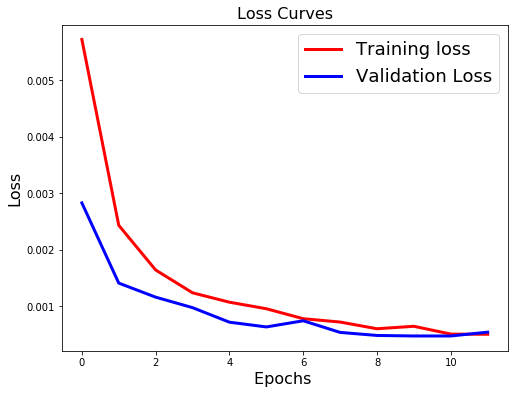

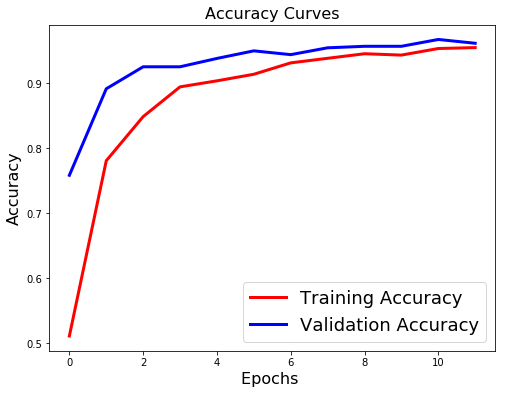

In [43]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['loss'],'r',linewidth=3.0)
plt.plot(history_1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['acc'],'r',linewidth=3.0)
plt.plot(history_1.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Model Two

In [18]:
model_2 = build_model()

In [19]:
opt = keras.optimizers.adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
image_gen = ImageDataGenerator(rotation_range=0, 
                             width_shift_range=0.05, 
                             height_shift_range=0.05, 
                             horizontal_flip=True)

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [21]:
history_2 = model_2.fit_generator(image_gen.flow(X_train, y_train, batch_size=20), 
                      validation_data=(X_test, y_test), callbacks=[es], verbose=1, epochs=100)

Epoch 1/100
228/228 [==============================] - 54s 237ms/step - loss: 0.0058 - acc: 0.5110 - val_loss: 0.0026 - val_acc: 0.8054
Epoch 2/100
228/228 [==============================] - 46s 201ms/step - loss: 0.0024 - acc: 0.7976 - val_loss: 0.0013 - val_acc: 0.9097
Epoch 3/100
228/228 [==============================] - 46s 201ms/step - loss: 0.0016 - acc: 0.8632 - val_loss: 9.5621e-04 - val_acc: 0.9132
Epoch 4/100
228/228 [==============================] - 46s 201ms/step - loss: 0.0013 - acc: 0.8840 - val_loss: 0.0011 - val_acc: 0.9229
Epoch 5/100
228/228 [==============================] - 46s 203ms/step - loss: 0.0011 - acc: 0.9053 - val_loss: 8.5607e-04 - val_acc: 0.9360
Epoch 6/100
228/228 [==============================] - 46s 203ms/step - loss: 9.5619e-04 - acc: 0.9219 - val_loss: 8.2506e-04 - val_acc: 0.9255
Epoch 7/100
228/228 [==============================] - 46s 202ms/step - loss: 8.9165e-04 - acc: 0.9221 - val_loss: 5.7844e-04 - val_acc: 0.9500
Epoch 8/100
228/228 [===

In [23]:
model_2.save('2_batch20_dsi.h5')

Text(0.5,1,'Accuracy Curves')

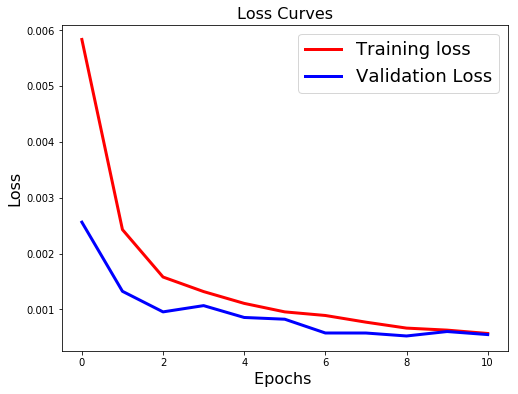

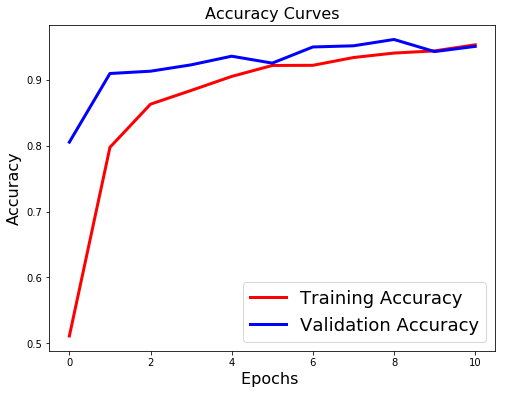

In [22]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_2.history['loss'],'r',linewidth=3.0)
plt.plot(history_2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_2.history['acc'],'r',linewidth=3.0)
plt.plot(history_2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)